## Notebook the combine the Langston's LRRK2 CRISPR experiments and take a preliminary look at the data

In [1]:
!date

Fri Jan  7 18:17:23 EST 2022


#### import libraries and set notebook variables

In [2]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize
from collections import OrderedDict
import MACA as maca
from matplotlib.pyplot import rc_context

import warnings
warnings.filterwarnings("ignore")

2022-01-07 18:17:25.939688: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [3]:
# naming
cohort = 'lrrk2_crispr'
expr_name_frmt = 'ci{expr_num}-gex-fb'

# directories
wrk_dir = '/labshare/LNG_Single_cell_data/Cookson_scCRISPRi_iMicroglia/modified_pipe_from_10x'

# in files
marker_db_url = 'https://raw.githubusercontent.com/ImXman/MACA/master/\
MarkerDatabase/human_motorcortex_bakken_markers.csv'

# out files
raw_merge_file = f'{wrk_dir}/{cohort}.merged.raw.h5ad'

# variables
expr_cnt = 3
debug = True
leiden_res = 0.5

#### helper functions

In [4]:
# determine targeted/non-targeted and what the target is
# multi-guide cells possible all guides same target?
def find_guide_target_values(guide_calls: np.ndarray, debug: bool=False) -> np.ndarray:
    target_arr = np.empty(len(guide_calls), dtype='object')
    for index in range(0, len(guide_calls)):
        # split the guides by list delimiter, pipe
        call_items = guide_calls[index].split('|')
        target = None
        for call_item in call_items:
            # target is 1st token, '_' is delimeter
            this_target = call_item.split('_')[0] 
            if target is None:
                target = this_target
            elif this_target != target:
                target = 'mixed'
                break
        target_arr[index] = target
    if debug:        
        unique, counts = np.unique(target_arr, return_counts=True)
        print(np.asarray((unique, counts)).T)
    return target_arr

# merge crispr guides with anndata obs
def add_guides_to_obs(this_obs: pd.DataFrame, guides_file_path: str) -> pd.DataFrame:
    # read and name the crispr guides
    guides_df = pd.read_csv(guides_file_path, index_col=0)
    # the SNP guides have slighty diff format that other guides, change to consistent
    guides_df.feature_call = guides_df.feature_call.str.replace('sg_rs', 'sgrs')
    guides_df['target'] = find_guide_target_values(guides_df.feature_call.to_numpy())
    # now merge guide info with anndata obs
    this_obs = this_obs.merge(guides_df, how='left', left_index=True, 
                              right_index=True)
    return this_obs

#### read 10X h5 files per experiment

In [5]:
%%time
exprs_list = []
for index in range(1, expr_cnt+1):
    expr_name = expr_name_frmt.format(expr_num=index)
    path_to_10x_h5 = f'{wrk_dir}/{expr_name}/filtered_feature_bc_matrix.h5'
    path_to_10X_guides = f'{wrk_dir}/{expr_name}/crispr_analysis/protospacer_calls_per_cell.csv'
    this_h5 = sc.read_10x_h5(path_to_10x_h5)
    this_h5.var_names_make_unique()
    this_h5.obs['expr_name'] = expr_name
    old_order = this_h5.obs.index.copy()    
    # add crispr guides to anndata obs
    this_h5.obs = add_guides_to_obs(this_h5.obs, path_to_10X_guides)
    print(f'index ok: {this_h5.obs.index.equals(old_order)}')    
    # add experiment to list
    exprs_list.append(this_h5)
    if debug:
        print(this_h5)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


index ok: True
AnnData object with n_obs × n_vars = 13277 × 36601
    obs: 'expr_name', 'num_features', 'feature_call', 'num_umis', 'target'
    var: 'gene_ids', 'feature_types', 'genome'


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


index ok: True
AnnData object with n_obs × n_vars = 31111 × 36601
    obs: 'expr_name', 'num_features', 'feature_call', 'num_umis', 'target'
    var: 'gene_ids', 'feature_types', 'genome'


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


index ok: True
AnnData object with n_obs × n_vars = 61295 × 36601
    obs: 'expr_name', 'num_features', 'feature_call', 'num_umis', 'target'
    var: 'gene_ids', 'feature_types', 'genome'
CPU times: user 15.7 s, sys: 880 ms, total: 16.6 s
Wall time: 16.6 s


#### concatenate the anndata objects

In [6]:
data = ad.concat(exprs_list)
data.obs_names_make_unique()
print(data)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 105683 × 36601
    obs: 'expr_name', 'num_features', 'feature_call', 'num_umis', 'target'


#### seems the anndata concat strips the var info add back

In [7]:
old_order = data.var.index.copy()
print(old_order[:5].values)
print(old_order[-5:].values)

['MIR1302-2HG' 'FAM138A' 'OR4F5' 'AL627309.1' 'AL627309.3']
['AC141272.1' 'AC023491.2' 'AC007325.1' 'AC007325.4' 'AC007325.2']


In [8]:
data.var = data.var.merge(exprs_list[0].var, how='left', 
                          left_index=True, right_index=True)

In [9]:
data.var.index.equals(old_order)

True

#### check the crispr guide target counts

where the target if not mixed can still include multiple guides that may have same target
can also check the num_features column to see how many guides

In [10]:
data.obs.target.value_counts()

mixed          46536
sgPeak38441    27650
sgNT            2294
sgPeak38433     1773
sgPeak38437     1399
sgPeak38440      824
sgPeak38439      429
sgrs7294619      106
Name: target, dtype: int64

In [11]:
data.obs.groupby('expr_name').target.value_counts()

expr_name   target     
ci1-gex-fb  mixed           4396
            sgPeak38441     3372
            sgNT             312
            sgPeak38433      251
            sgPeak38437      210
            sgPeak38440      112
            sgPeak38439       62
            sgrs7294619        6
ci2-gex-fb  mixed          10789
            sgPeak38441     8496
            sgNT             731
            sgPeak38433      605
            sgPeak38437      445
            sgPeak38440      263
            sgPeak38439      148
            sgrs7294619       38
ci3-gex-fb  mixed          31351
            sgPeak38441    15782
            sgNT            1251
            sgPeak38433      917
            sgPeak38437      744
            sgPeak38440      449
            sgPeak38439      219
            sgrs7294619       62
Name: target, dtype: int64

In [12]:
data.obs.loc[data.obs.num_features == 1 ].groupby('expr_name').target.value_counts()

expr_name   target     
ci1-gex-fb  sgPeak38441    1794
            sgNT            277
            sgPeak38433     232
            sgPeak38437     203
            sgPeak38440     108
            sgPeak38439      58
            sgrs7294619       6
ci2-gex-fb  sgPeak38441    4543
            sgNT            684
            sgPeak38433     560
            sgPeak38437     424
            sgPeak38440     253
            sgPeak38439     147
            sgrs7294619      38
ci3-gex-fb  sgPeak38441    6945
            sgNT           1134
            sgPeak38433     838
            sgPeak38437     697
            sgPeak38440     431
            sgPeak38439     214
            sgrs7294619      62
Name: target, dtype: int64

#### save raw merge without pre-processing

In [13]:
%%time
data.write(raw_merge_file)

... storing 'expr_name' as categorical
... storing 'feature_call' as categorical
... storing 'num_umis' as categorical
... storing 'target' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


CPU times: user 2.49 s, sys: 1.43 s, total: 3.92 s
Wall time: 30.7 s


### Preprocessing

#### Show those genes that yield the highest fraction of counts in each single cell, across all cells.

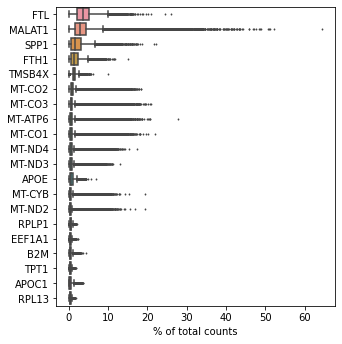

In [14]:
sc.pl.highest_expr_genes(data, n_top=20, )

#### Basic filtering:

In [15]:
sc.pp.filter_cells(data, min_genes=200)
sc.pp.filter_genes(data, min_cells=3)
data.var['mt'] = data.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(data, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

#### visualize counts and mito percentages

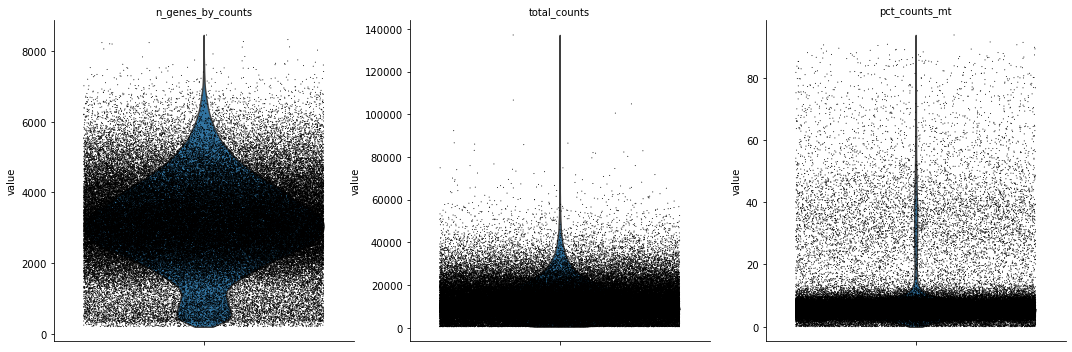

In [16]:
sc.pl.violin(data, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

#### Remove cells that have too many mitochondrial genes expressed or too many total counts:

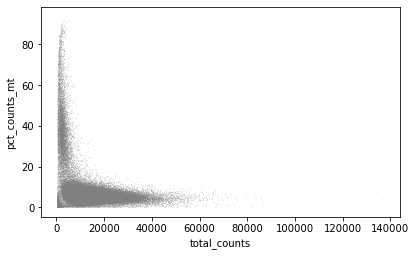

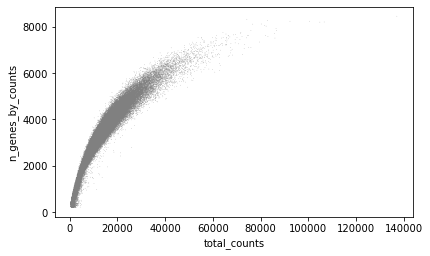

In [17]:
sc.pl.scatter(data, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(data, x='total_counts', y='n_genes_by_counts')

In [18]:
data = data[data.obs.n_genes_by_counts < 7000, :]
data = data[data.obs.pct_counts_mt < 10, :]

### Setup data for clustering

#### cluster on log1p normalized data

In [19]:
# create a layer containing the raw data 
data.layers['raw'] = data.X

In [20]:
# normalize and scale 
scale_num = 10000
data.layers['norm'] = normalize(data.X, norm='l1', axis=1)*scale_num

# log1p 
data.layers['log1p'] = np.log1p(data.layers['norm'])
data.uns = OrderedDict([('log1p', {'base':None})])
data.X = data.layers['log1p']

### Clustering without batch correction

#### set X to log1p and scale 

In [21]:
data.X = data.layers['log1p']
sc.pp.scale(data, max_value=10)

In [22]:
# parameters used to find highly variable genes 
n_top_genes = 6000
n_bins = 20
flavor= 'seurat'

In [23]:
# Friendly reminder - this requires log data
sc.pp.highly_variable_genes(data, n_top_genes=n_top_genes, 
                            flavor=flavor, n_bins=n_bins)

#### Cluster the nuclei

In [24]:
sc.tl.pca(data, svd_solver='arpack', use_highly_variable=True, n_comps=10)

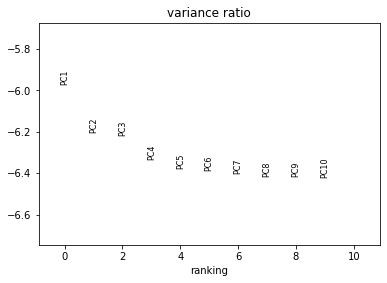

In [25]:
sc.pl.pca_variance_ratio(data, log=True, n_pcs=10)

In [26]:
sc.pp.neighbors(data, n_neighbors=30, n_pcs=10, knn=True)
sc.tl.leiden(data, resolution = leiden_res)

#### embed the neighborhood graph using UMAP 

In [27]:
sc.tl.umap(data)

#### plot UMAP by experiment 

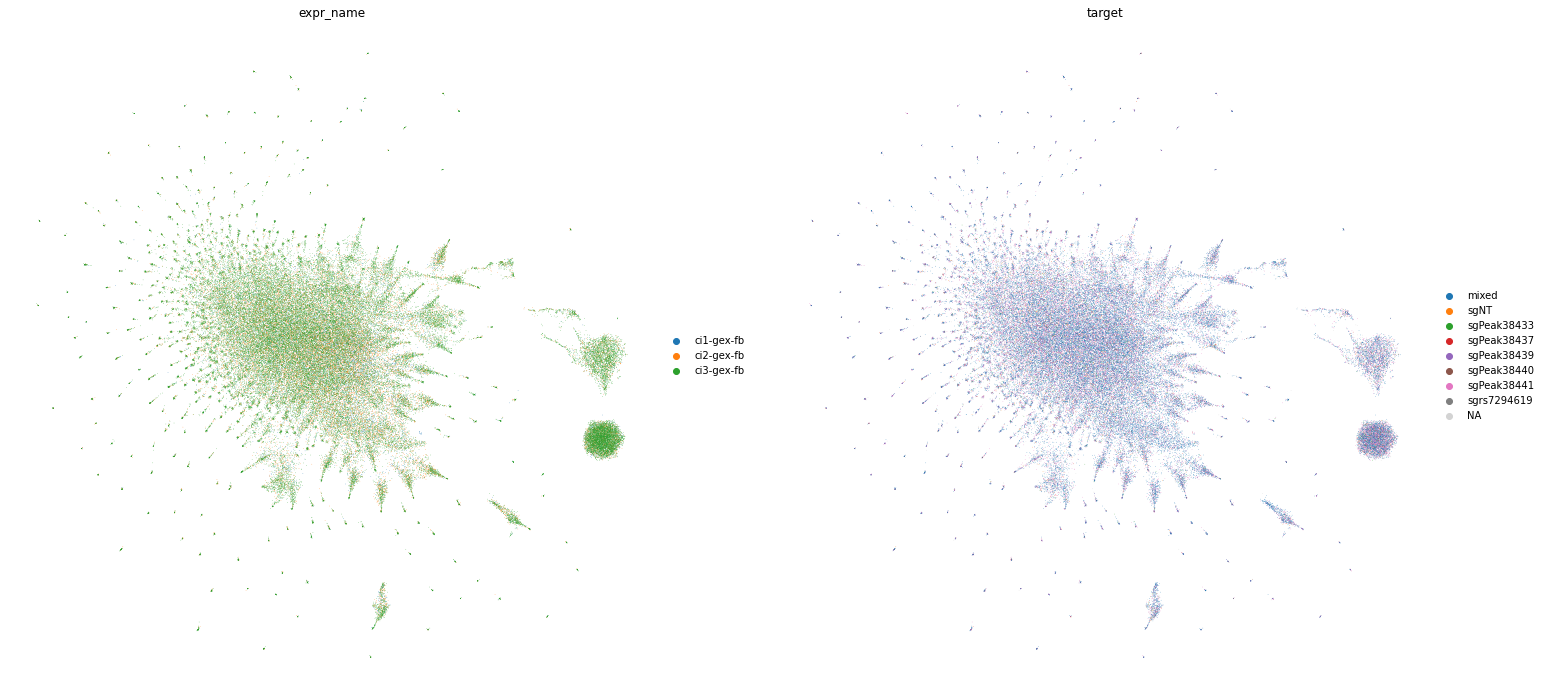

In [38]:
with rc_context({'figure.figsize': (12, 12)}):
    sc.pl.umap(data, color=['expr_name', 'target'], use_raw=False, frameon=False)

In [29]:
data

AnnData object with n_obs × n_vars = 93973 × 24579
    obs: 'expr_name', 'num_features', 'feature_call', 'num_umis', 'target', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'expr_name_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw', 'norm', 'log1p'
    obsp: 'distances', 'connectivities'

In [30]:
data.obs['leiden'].value_counts()

0      22873
1      15394
2       7475
3       6676
4       4180
       ...  
163       14
164       14
165       14
166       13
167       13
Name: leiden, Length: 168, dtype: int64

### find cell types using MACA

#### parse in MACA marker database, using Bakken

In [31]:
markers_df = pd.read_csv(marker_db_url)
print(markers_df.shape)
display(markers_df.head())
#cell_marker is dictionary that contains names of cell types and their marker genes
cell_markers = {}
marker_list = []
for i in list(set(markers_df.columns.values.tolist())):
    genes = markers_df[i].values.tolist()
    cell_markers[i]=genes
    marker_list+= genes
marker_list = list(set(marker_list))
marker_list = [i for i in marker_list if i in data.var.index]
len(marker_list)

(20, 20)


,Pvalb,L5 IT,Sst,OPC,L6 IT Car3,VLMC,L5/6 NP,L6b,Vip,L6 CT,Endo,L6 IT,Astro,Sst Chodl,L2/3 IT,Oligo,Micro-PVM,L5 ET,Sncg,Lamp5
0,ADAMTS17,LOC105374971,SST,VCAN,LOC105378486,COLEC12,NPSR1-AS1,LOC401134,VIP,ADAMTSL1,ABCB1,LOC105371832,RNF219-AS1,NPY,CUX2,ST18,DOCK8,LOC105378657,CXCL14,FGF13
1,BTBD11,LOC105377703,GRIK1,LHFPL3,ZNF804B,LINC01088,HTR2C,MDFIC,GALNTL6,HS3ST4,FLT1,THEMIS,ADGRV1,NOS1,LINC00507,PLP1,ADAM28,COL5A2,CNR1,EYA4
2,ERBB4,LOC102546299,NXPH1,PDGFRA,TRPC5,LOC105377979,TSHZ2,HS3ST4,TAC3,SEMA3E,HERC2P3,LOC105373893,LOC101927437,CRHBP,LINC01378,MOBP,APBB1IP,LOC105369860,CHRNA7,KIT
3,CNTNAP3B,FSTL4,COL25A1,COL9A1,ATP10A,DCN,TLL1,MCTP2,ADARB2,LOC105373592,MECOM,ADAMTS3,AQP4,SST,CA10,ENPP2,P2RY12,VAT1L,ADARB2,PDGFD
4,LOC101929680,RORB,FLT3,PTPRZ1,NTNG2,LOC102467224,ITGA8,NPFFR2,SYNPR,EGFEM1P,ABCG2,LOC101928278,SLC1A2,STAC,HS6ST3,LOC101927967,ST6GAL1,LOC101927745,NR2F2-AS1,PRELID2


221

#### compute MACA cell assignments

In [32]:
%%time
adata = data.copy()
adata = adata[:,marker_list]

##run MACA
adata, annotation = maca.singleMACA(ad=adata, cell_markers=cell_markers,
                                 res=[1,1.5,2],n_neis=[3,5,10])
##we define louvain clustering resolution 1, 1.5 and 2; 
##number of neighbors to define the kNN is 3,5 and 10 separately.
##MACA will get 9 clustering results, using this set of parameteres.
##The final annotation is ensembled via voting.

Trying to set attribute `.obs` of view, copying.


(93973, 20)
(93973, 20)
CPU times: user 45min 44s, sys: 15min 24s, total: 1h 1min 9s
Wall time: 3min 14s


In [33]:
adata.obs['celltype'] = np.array(annotation)

#### visualize the MACA cell assignments

... storing 'Mapped' as categorical
... storing 'celltype' as categorical


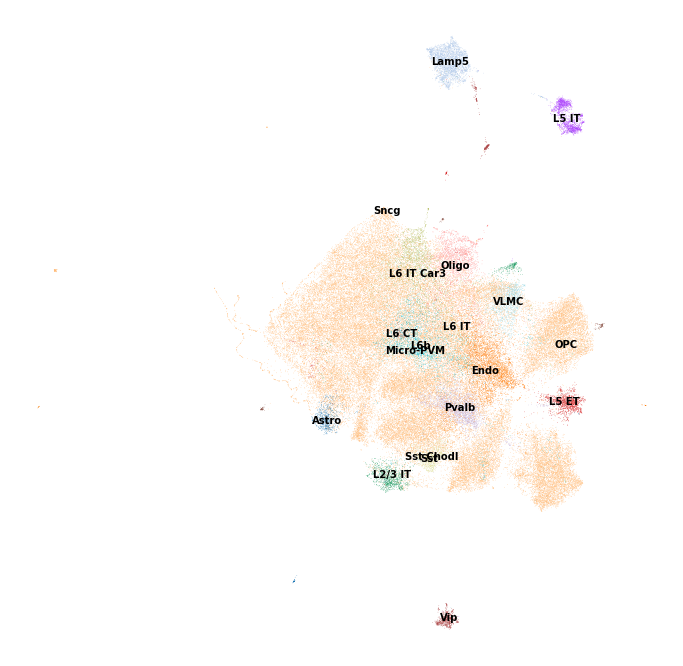

In [34]:
with rc_context({'figure.figsize': (12, 12)}):
    sc.pl.umap(adata, color='celltype', legend_loc='on data', title='', frameon=False)

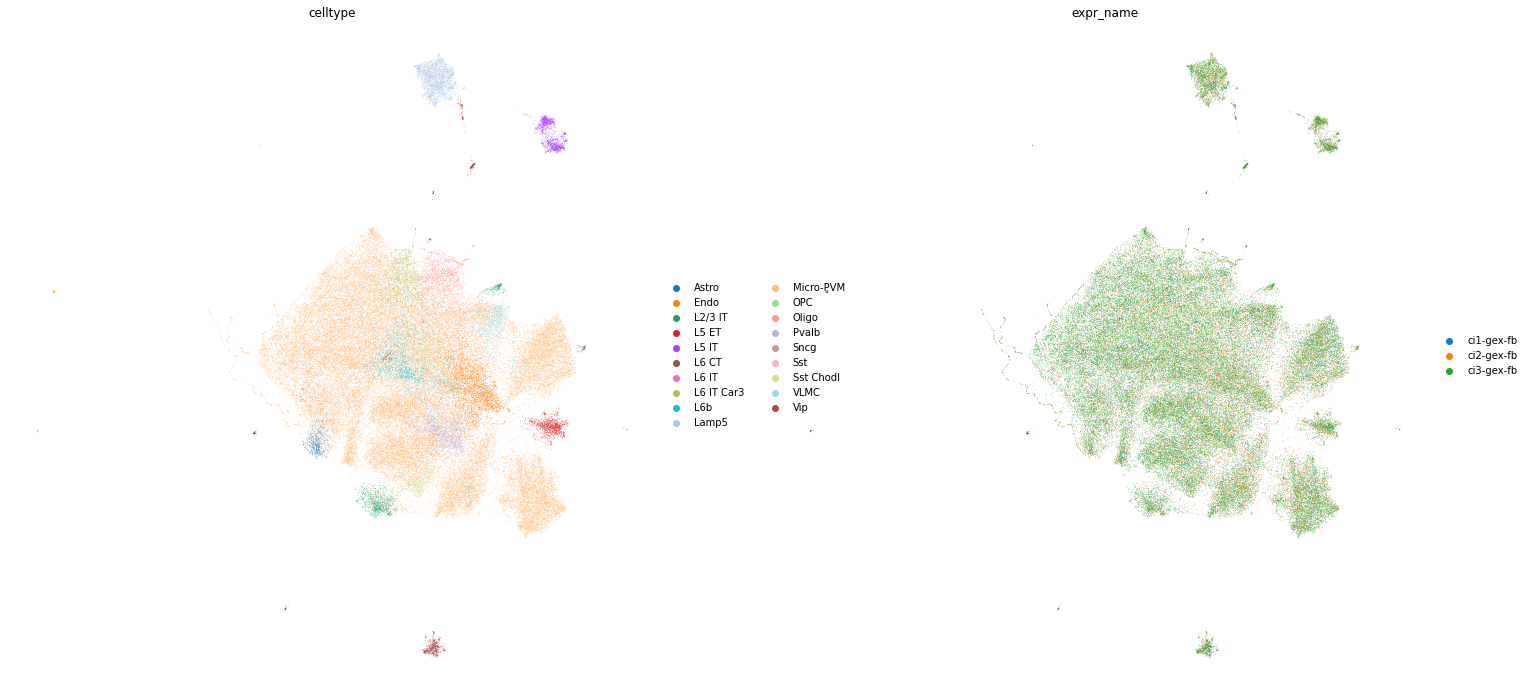

In [35]:
with rc_context({'figure.figsize': (12, 12)}):
    sc.pl.umap(adata, color=['celltype', 'expr_name'], frameon=False)

In [36]:
adata.obs['celltype'].value_counts()

Micro-PVM     66039
Endo           4959
Lamp5          3121
Oligo          2831
L6 IT Car3     2777
L6b            2554
Pvalb          2321
L5 IT          1662
L5 ET          1649
L2/3 IT        1487
VLMC           1309
Vip            1143
Sst Chodl       885
Astro           841
L6 CT           315
OPC              54
L6 IT            16
Sst               8
Sncg              2
Name: celltype, dtype: int64

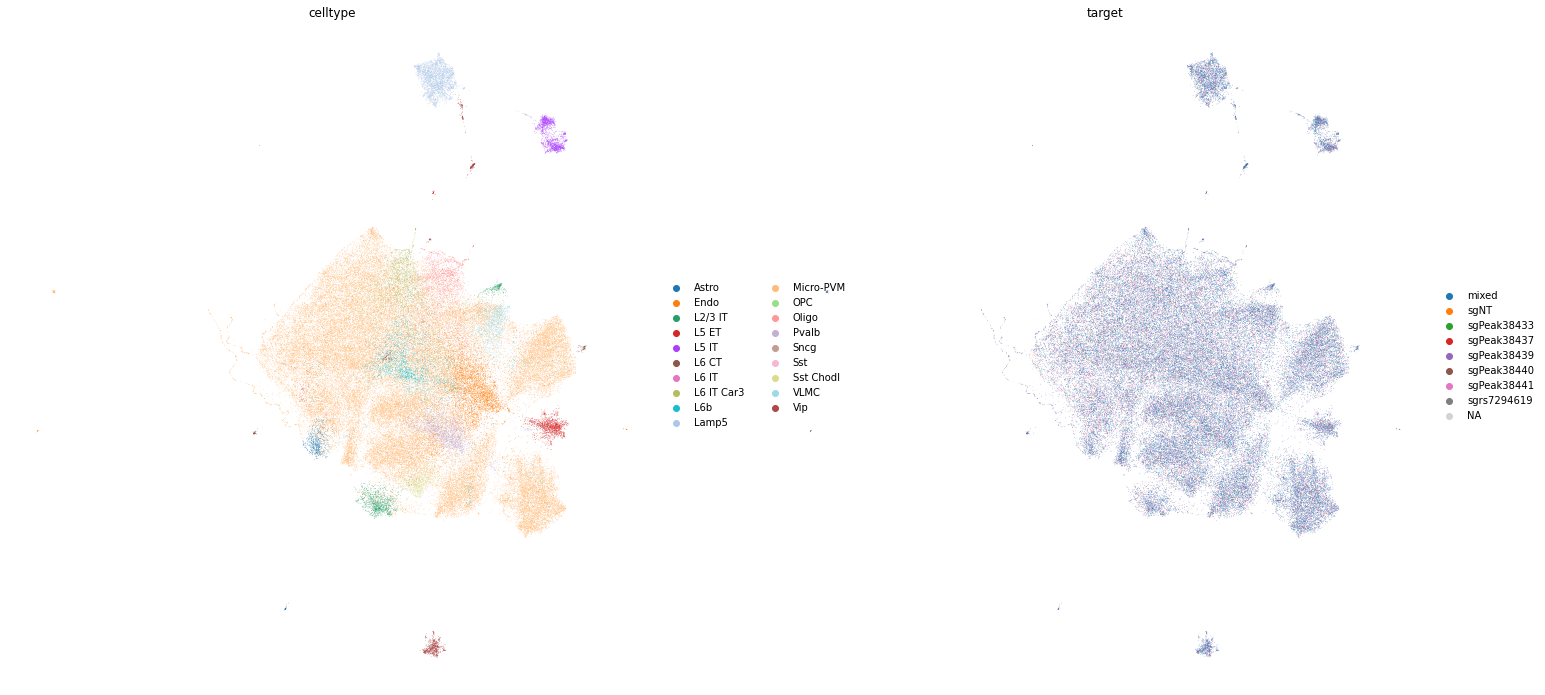

In [37]:
with rc_context({'figure.figsize': (12, 12)}):
    sc.pl.umap(adata, color=['celltype', 'target'], frameon=False)